In [1]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import os
import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia.record import Record, load_file
from antlia.dtype import load_converted_record
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

In [3]:
with open('../config.p', 'rb') as f:
        bicycle_calibration = pickle.load(f)

bicycle_rec = load_file(
    '../../data/comfort/2018-04-23_12-30-38.csv', bicycle_calibration['convbike'])
lidar_rec = load_converted_record(
    '../../data/comfort/2018-04-23-12-17-37_0.pkl.gz')

r = Record(lidar_rec, bicycle_rec)

In [4]:
# manually sync to save time
r.synced = 18.512
time_offset = r.bicycle.time[0] - r.lidar.time[0]
r.bicycle.time += r.synced - time_offset

# denote missing sync signal at t=680 sec
r._calculate_trials2(missing_sync=[680])

#r.sync()

In [ ]:
import IPython.display

def display_animation(animation):
    plt.close(animation._fig)
    return IPython.display.HTML(animation.to_jshtml())
    
display_animation(r.lidar.frame(lambda t: (t > 1172) & (t < 1190)).animate(
    xlim=(-40, 110),
    ylim=(0, 4),
    rlim=(0, 110)))

In [ ]:
DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook

plt.close()
colors = sns.color_palette('Paired', 12)
fig, ax = plt.subplots(2, 1, sharex=True)

i = 0
for t in r.trials:
    ax[0].plot(t.data.time, t.data.speed > 1, color=colors[i])
    ax[1].plot(t.lidar.time,
               t.lidar.cartesian(xlim=(0, 60), ylim=(0, 4))[0].count(axis=1) > 1,
               color=colors[i])
    i = i ^ 1
    
    t0, t1 = t.event_timerange
    ax[0].axvspan(t0, t1, color=colors[5], alpha=0.5)
    ax[1].axvspan(t0, t1, color=colors[5], alpha=0.5)
    
ax[0].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 
ax[1].plot(r.bicycle.time, r.bicycle.sync, color=colors[3]) 

plt.show()

In [ ]:
DEAFAULT_FIGSIZE = (16, 12)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib inline

for trial in r.trials:
    t0, t1 = trial.event_timerange
    d = display_animation(r.lidar.frame(lambda t: (t > t0) & (t < t1)).animate(
        xlim=(-40, 40),
        ylim=(0, 4),
        rlim=(0, 110),
        figsize=DEFAULT_FIGSIZE))
    IPython.display.display(d)

In [ ]:
import scipy.signal

DEFAULT_FIGSIZE = (12, 8)
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
%matplotlib notebook
%matplotlib notebook

plt.close('all')
color = sns.color_palette('Paired', 12)
fig, ax = plt.subplots(len(r.trials), 2)
for i, trial in enumerate(r.trials):
    i0, i1 = trial.event_indices
    print(i0, i1)
    bicycle_event = trial.bicycle[i0:i1]
    
    ax[i, 0].plot(bicycle_event.time, bicycle_event['speed'], color=color[0])
    ax[i, 1].plot(bicycle_event.time, bicycle_event['steer angle'], color=color[2])
    
    # filter speed
    fc = 1
    fs = 1/trial.period
    x = bicycle_event['speed']
    
    order = 3
    wn = fc / (0.5*fs)
    b, a = scipy.signal.butter(order, wn, btype='lowpass')
    filtered_speed = scipy.signal.filtfilt(b, a, x)
    
    ax[i, 0].plot(bicycle_event.time, filtered_speed, color=color[1])
    
    # highlight first quarter and last eighth
    a0 = i0
    a1 = int(a0 + (i1 - i0)/8)
    b1 = i1
    b0 = int(b1 - (i1 - i0)/8)
    
    ax[i, 0].axvspan(trial.bicycle.time[a0], trial.bicycle.time[a1], color=color[4], alpha=0.5)
    ax[i, 0].axvspan(trial.bicycle.time[b0], trial.bicycle.time[b1], color=color[4], alpha=0.5)
    
    v0 = np.mean(trial.bicycle.speed[a0:a1])
    v1 = np.mean(trial.bicycle.speed[b0:b1])
    print('speed: first eighth, last eighth, ratio', v0, v1, v1/v0)
    if v1/v0 < 0.9:
        print('braking')
    else:
        print('overtaking')
plt.show() 

(array([ (-0.87650969,  116.30284365, -0.95428868,   2.13373611e-285,  0.01181371,  3.94484647,  4.336545,  8.02212779,  128.40981,  132.746355, 55, [12610, 13152], 0, 0, 0)],
      dtype=[('linregress slope', '<f8'), ('linregress intercept', '<f8'), ('linregress r-value', '<f8'), ('linregress p-value', '<f8'), ('linregress stderr', '<f8'), ('starting velocity', '<f8'), ('braking duration', '<f8'), ('braking distance', '<f8'), ('braking starttime', '<f8'), ('braking endtime', '<f8'), ('window size', '<i8'), ('braking range', '<i8', (2,)), ('lockup ranges', '<i8'), ('rider id', '<i8'), ('trial id', '<i8')]), array([ 0.00064302,  0.00066976,  0.00069645, ...,  0.00069645,
        0.00066976,  0.00064302]), array([-0.08772524, -0.09117861, -0.09444522, ..., -0.18550772,
       -0.17930928, -0.17321132]), [])

(array([ (-1.53265701,  891.48550876, -0.93810459,   9.42644013e-187,  0.02825787,  4.98557784,  3.25641,  8.65717668,  578.297376,  581.553786, 55, [53474, 53877], 0, 0, 0)],
      

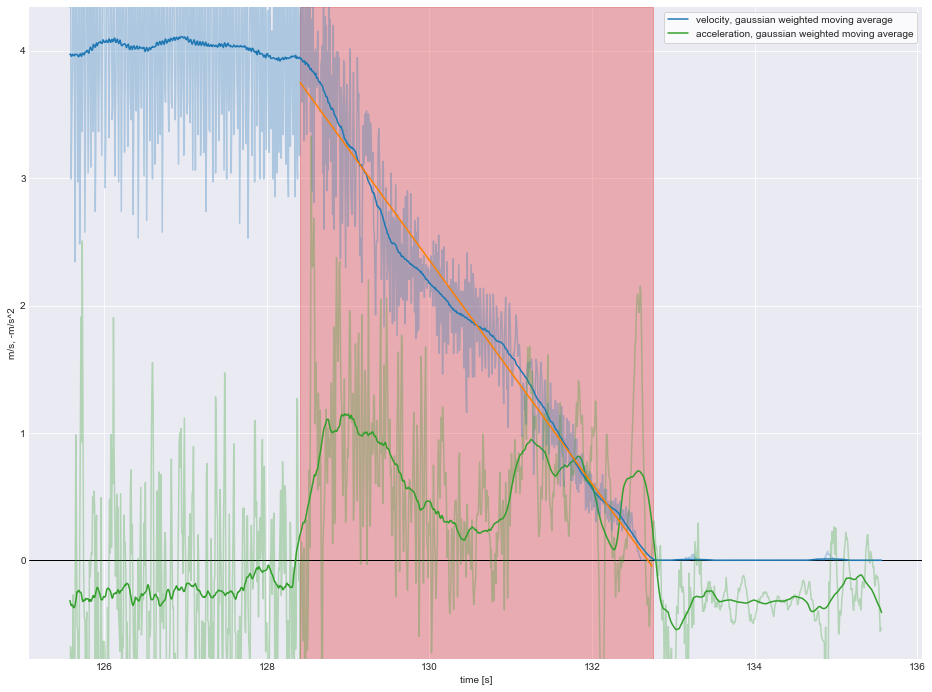

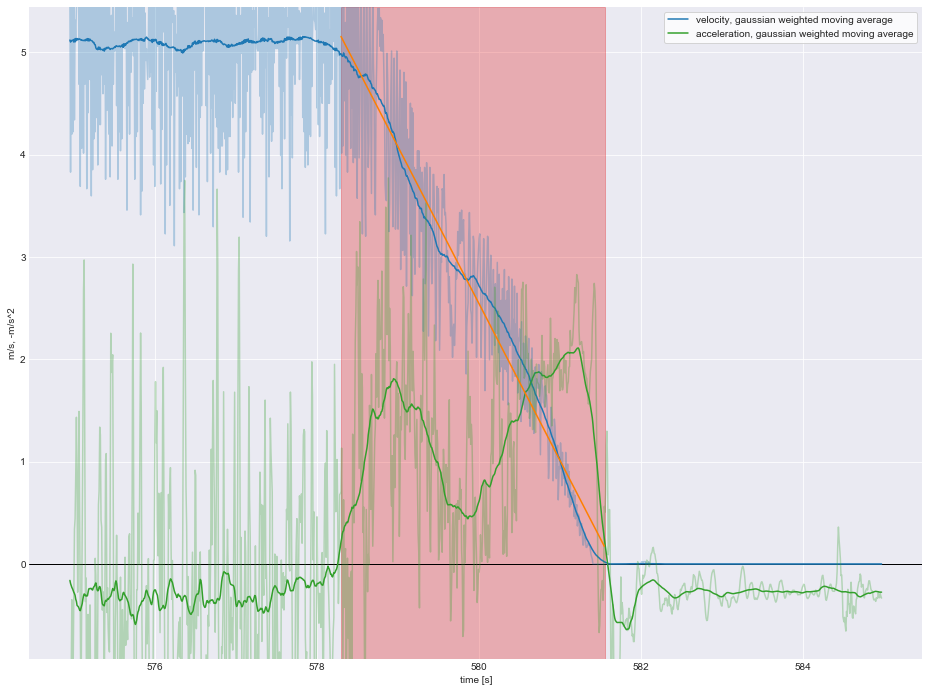

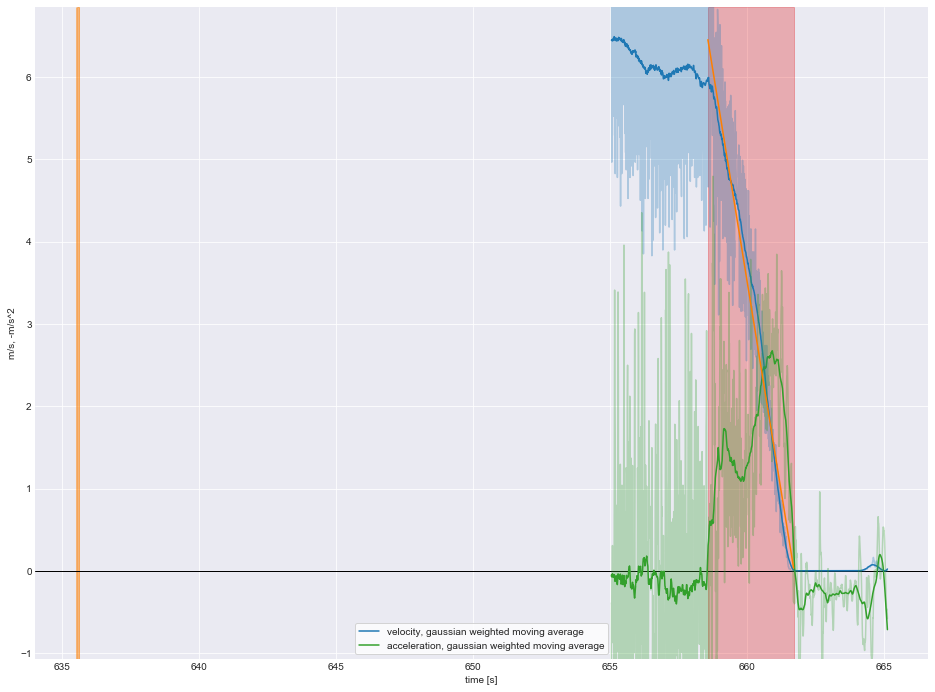

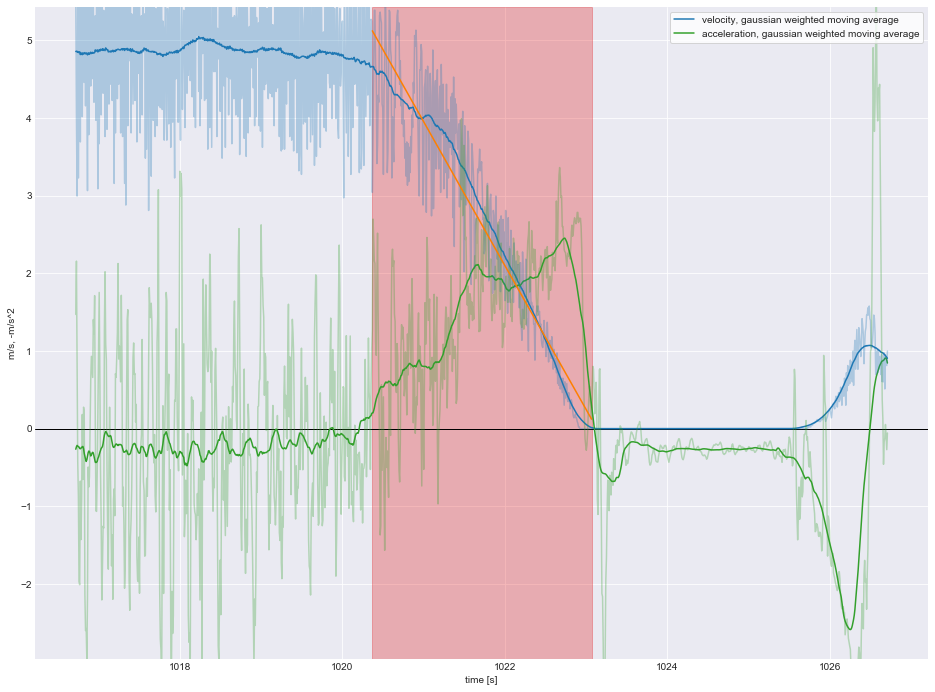

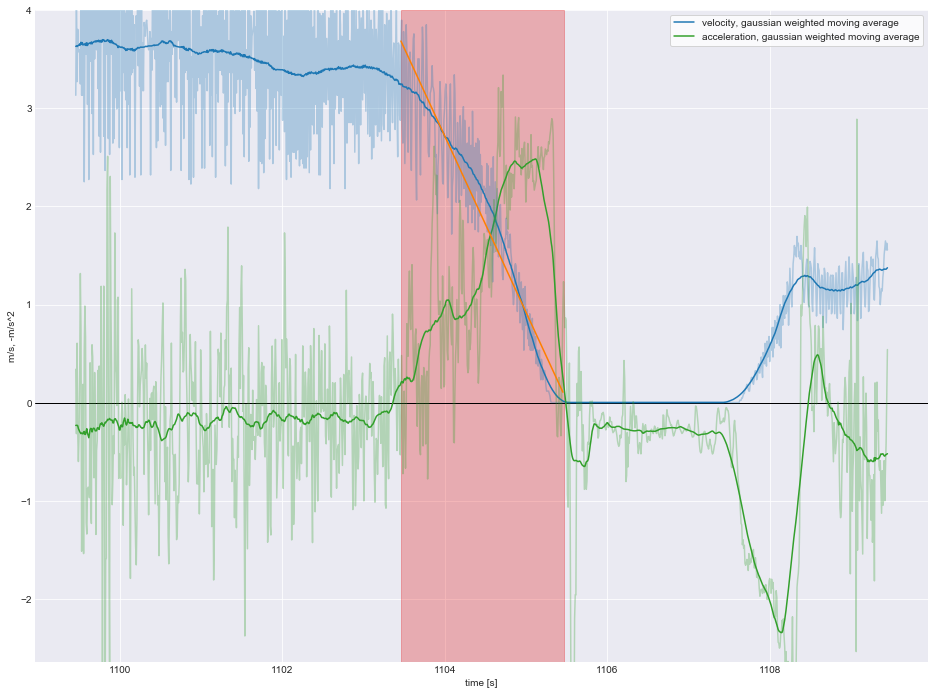

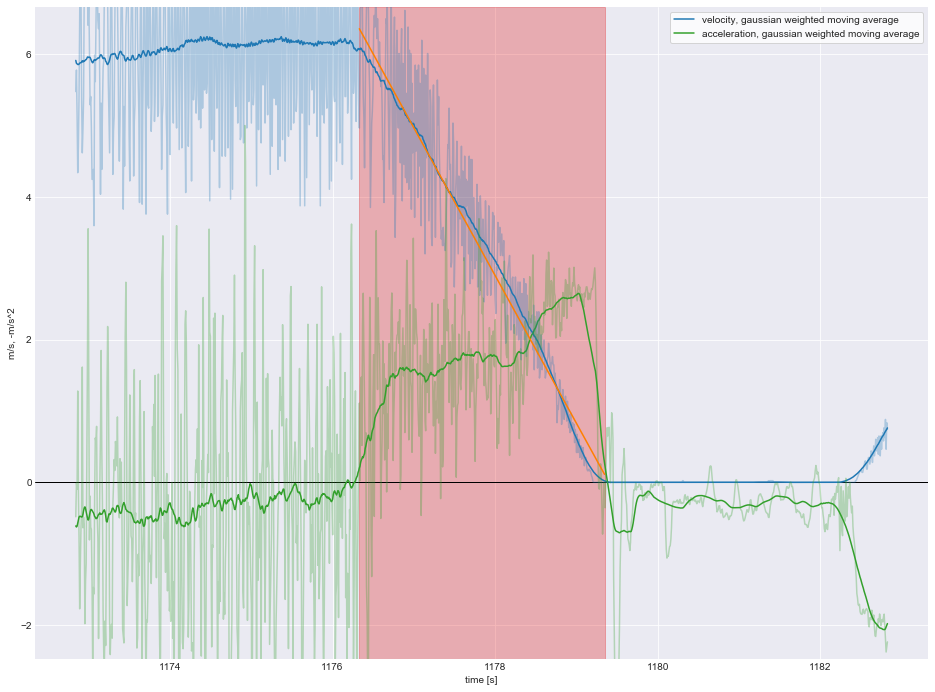

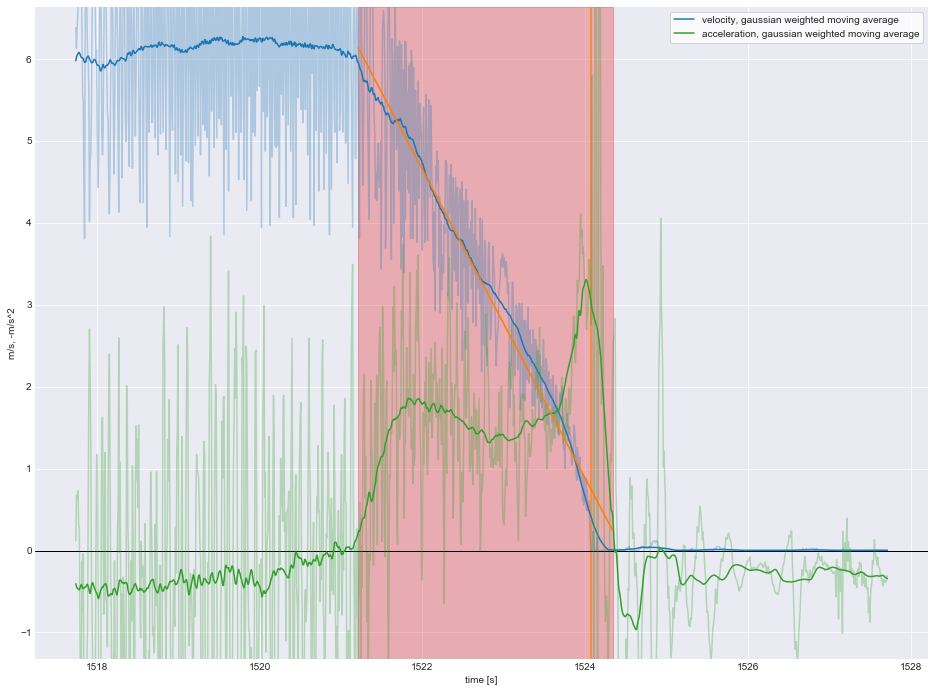

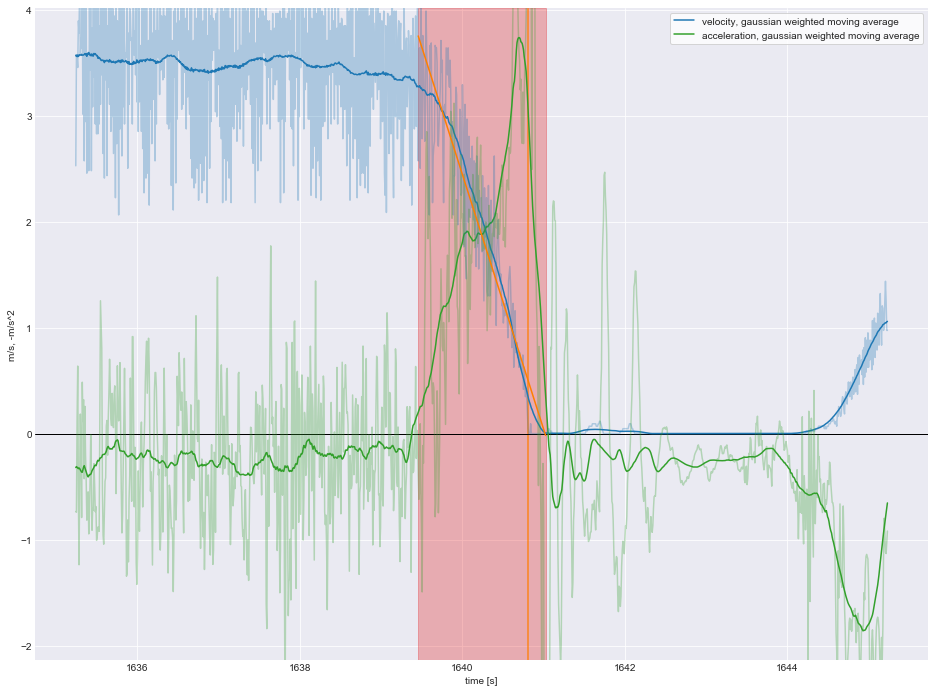

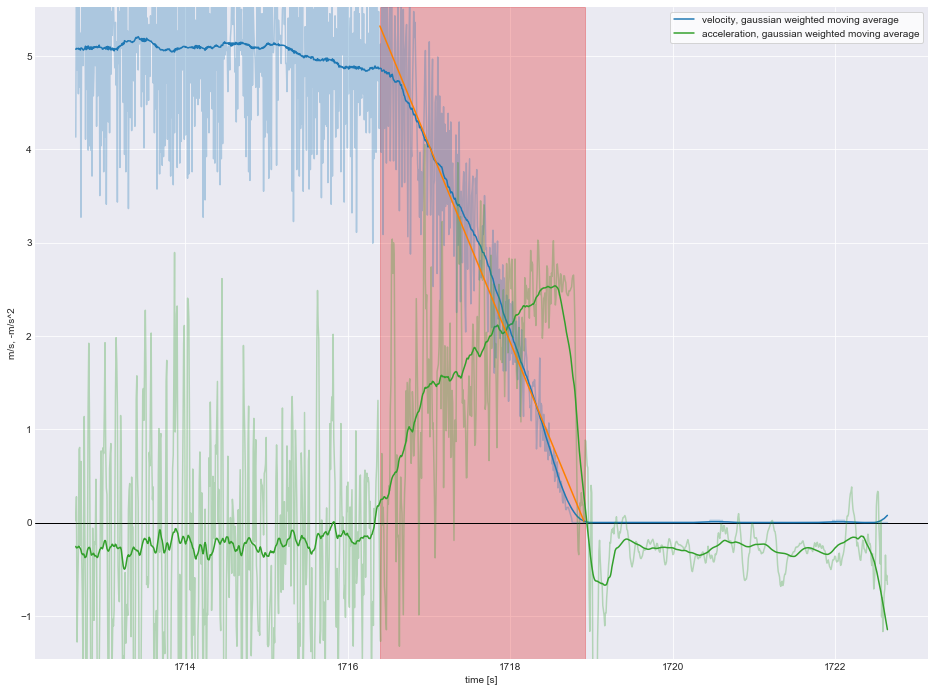

In [9]:
from antlia.trial2 import EventType
from antlia import plot_braking as braking

plt.close('all')
for trial in r.trials:
    if trial.event_type != EventType.Braking:
        continue
    
    metrics_kw = {'braking_threshold': 0.2, 'min_size': 30}
        
    m = braking.get_metrics(trial.bicycle, **metrics_kw)
    print(m)
    print()
    
    braking.plot_trial_braking_event(
        trial.bicycle, metrics_kw=metrics_kw)
    
plt.show()